In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
# following Chollet's example at https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb

In [5]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(244, 244, 3))
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 250, 250, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 122, 122, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 122, 122, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Step 1 - train new classifier with frozen base model

In [6]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Flatten, AveragePooling2D, Dropout

resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
resnet.trainable = False
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [7]:
# following Adrian Rosebock's example @ https://www.pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/

class_model = resnet.output
class_model = AveragePooling2D(pool_size=(7, 7))(class_model)
class_model = Flatten(name="flatten")(class_model)
class_model = Dense(256, activation="relu")(class_model)
class_model = Dropout(0.5)(class_model)
class_model = Dense(10, activation="softmax")(class_model)

model = Model(inputs=resnet.input, outputs=class_model)
# from tensorflow.keras import Sequential
# model = Sequential()
# model.add(resnet)
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(10, activation='softmax'))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [1]:
from load_data import load_data_gen

# data_gen_params = {
#     "rotation_range": 40,
#     "width_shift_range": 0.2,
#     "height_shift_range": 0.2,
#     "shear_range": 0.2,
#     "zoom_range": 0.2,
#     "horizontal_flip": True,
# }
(train_data, val_data, test_data) = load_data_gen(task=2, img_dims=244)

Found 6790 images belonging to 10 classes.
Found 750 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [9]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from utils import data_fldr

# data_gen_params = {
#     "rotation_range": 40,
#     "width_shift_range": 0.2,
#     "height_shift_range": 0.2,
#     "shear_range": 0.2,
#     "zoom_range": 0.2,
#     "horizontal_flip": True,
# }
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.1)
# train_data = train_datagen.flow_from_directory(
#     f"{data_fldr}/imagewoof-320/train",
#     batch_size=32,
#     shuffle=True,
#     subset="training",
#     target_size=(244, 244),
#     class_mode='categorical')
# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.1)
# val_data = test_datagen.flow_from_directory(
#     f"{data_fldr}/imagewoof-320/train",
#     batch_size=32,
#     target_size=(244, 244),
#     shuffle=True,
#     subset="validation",
#     class_mode='categorical')
# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# test_data = test_datagen.flow_from_directory(
#     f"{data_fldr}/imagewoof-320/val",
#     batch_size=32,
#     target_size=(244, 244),
#     shuffle=False,
#     class_mode='categorical')

In [15]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  print(labels_batch[1])
  break

(32, 244, 244, 3)
(32, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [11]:
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
)

Epoch 1/5
351/351 [==============================] - 131s 351ms/step - loss: 0.6357 - accuracy: 0.8059 - val_loss: 0.2076 - val_accuracy: 0.9301

39/39 [==============================] - 7s 185ms/step - loss: 0.1872 - accuracy: 0.9373

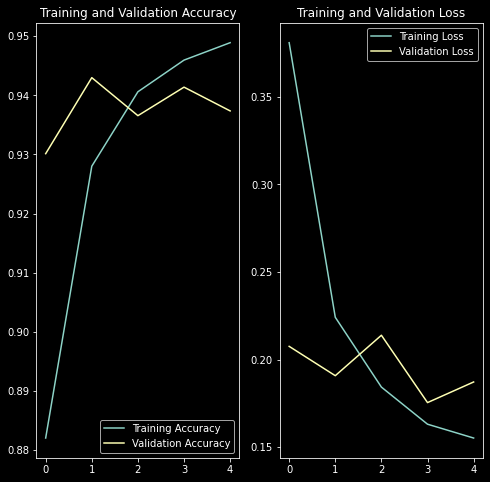

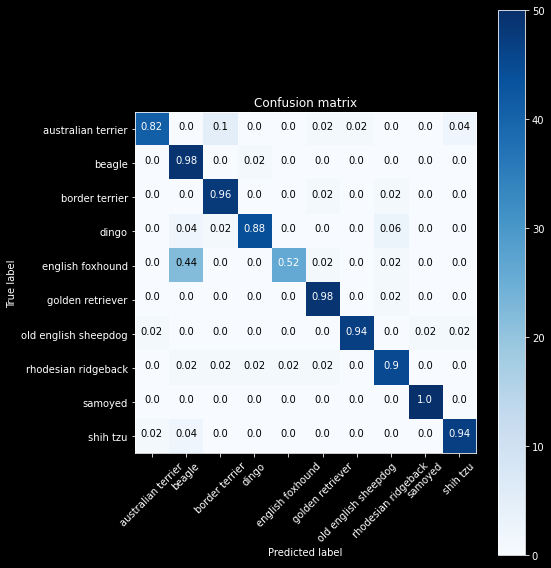

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
from utils import plot_training, plot_confusion_matrix

val_result = model.evaluate(val_data)
print(f"Final validation results: {dict(zip(model.metrics_names, val_result))}")
result = model.evaluate(test_data)
print(f"Final test results: {dict(zip(model.metrics_names, result))}")
plot_training(history)
# print(f"FLOPS: {get_flops(model)}")
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_data.classes, y_pred)
print(classification_report(test_data.classes, y_pred, target_names=test_data.class_indices.keys()))
plot_confusion_matrix(cm, test_data.class_indices.keys())

as expected the model's performance is hampered by the under-represented class english foxhound which is being confused
for the similar class beagle. Fine-tuning may improve the accuracy slightly (potentially) but to see any significant
boost to performance the model should be weighted or the under-represented class should be oversampled

In [30]:
# save initial model trained on imbalanced dataset
model.save("../saved_models/initial_imbalanced.h5")

# testing class weights to balance
taking inspiration from: https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

from the exploration notebook we know that there are 754 images of the english foxhound class and 1300 of all others in the train set
need to weight the under-represented class by 1300/754

In [21]:
# testing class weights to balance
# https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
print(test_data.class_indices)

class_weight = {
    0: 1.,
    1: 1.,
    2: 1.,
    3: 1.,
    4: 1300./754.,
    5: 1.,
    6: 1.,
    7: 1.,
    8: 1.,
    9: 1.,
}
class_weight

{'australian terrier': 0, 'beagle': 1, 'border terrier': 2, 'dingo': 3, 'english foxhound': 4, 'golden retriever': 5, 'old english sheepdog': 6, 'rhodesian ridgeback': 7, 'samoyed': 8, 'shih tzu': 9}


{0: 1.0,
 1: 1.0,
 2: 1.0,
 3: 1.0,
 4: 1.7241379310344827,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 1.0,
 9: 1.0}

lets reload the data and model and train from scratch and see if this helps, but run for longer to give the model a chance to learn the bias

In [24]:
(train_data, val_data, test_data) = load_data_gen(task=2, img_dims=244)
resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
resnet.trainable = False
class_model = resnet.output
class_model = AveragePooling2D(pool_size=(7, 7))(class_model)
class_model = Flatten(name="flatten")(class_model)
class_model = Dense(256, activation="relu")(class_model)
class_model = Dropout(0.5)(class_model)
class_model = Dense(10, activation="softmax")(class_model)

model = Model(inputs=resnet.input, outputs=class_model)
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    class_weight=class_weight
)

Found 11209 images belonging to 10 classes.
Found 1245 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Epoch 1/30
351/351 [==============================] - 77s 214ms/step - loss: 0.6793 - accuracy: 0.8049 - val_loss: 0.1925 - val_accuracy: 0.9333

39/39 [==============================] - 8s 208ms/step - loss: 0.3029 - accuracy: 0.9454

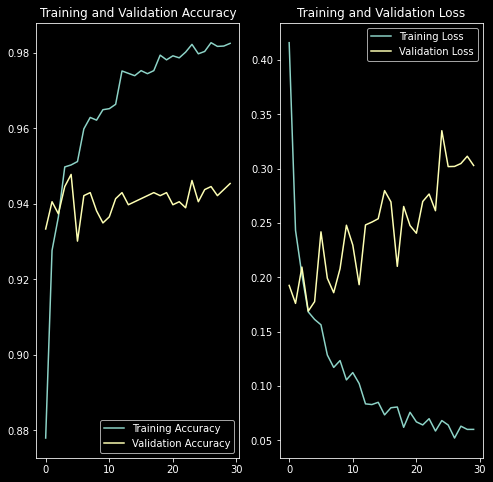

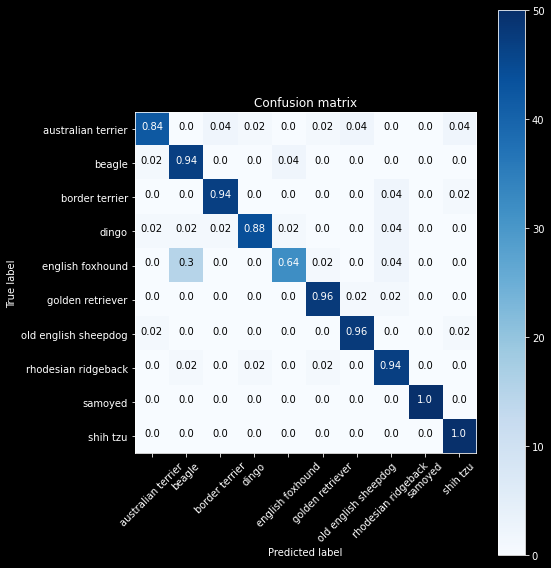

In [25]:
val_result = model.evaluate(val_data)
print(f"Final validation results: {dict(zip(model.metrics_names, val_result))}")
result = model.evaluate(test_data)
print(f"Final test results: {dict(zip(model.metrics_names, result))}")
plot_training(history)
# print(f"FLOPS: {get_flops(model)}")
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_data.classes, y_pred)
print(classification_report(test_data.classes, y_pred, target_names=test_data.class_indices.keys()))
plot_confusion_matrix(cm, test_data.class_indices.keys())

slight improvement, maybe adding image augmentation will help at this stage? Assuming the bias is starting to be learned,
let's continue training with data augmentation

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from utils import data_fldr

data_gen_params = {
    "rotation_range": 40,
    "width_shift_range": 0.2,
    "height_shift_range": 0.2,
    "shear_range": 0.2,
    "zoom_range": 0.2,
    "horizontal_flip": True,
}
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.1, **data_gen_params)
train_data = train_datagen.flow_from_directory(
    f"{data_fldr}/imagewoof-320/train",
    batch_size=32,
    shuffle=True,
    subset="training",
    target_size=(244, 244),
    class_mode='categorical')
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.1)
val_data = test_datagen.flow_from_directory(
    f"{data_fldr}/imagewoof-320/train",
    batch_size=32,
    target_size=(244, 244),
    shuffle=True,
    subset="validation",
    class_mode='categorical')
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_datagen.flow_from_directory(
    f"{data_fldr}/imagewoof-320/val",
    batch_size=32,
    target_size=(244, 244),
    shuffle=False,
    class_mode='categorical')
train_data.class_indices.keys()

Found 11209 images belonging to 10 classes.
Found 1245 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


dict_keys(['australian terrier', 'beagle', 'border terrier', 'dingo', 'english foxhound', 'golden retriever', 'old english sheepdog', 'rhodesian ridgeback', 'samoyed', 'shih tzu'])

Epoch 1/30
351/351 [==============================] - 137s 390ms/step - loss: 0.3779 - accuracy: 0.8961 - val_loss: 0.2540 - val_accuracy: 0.9398

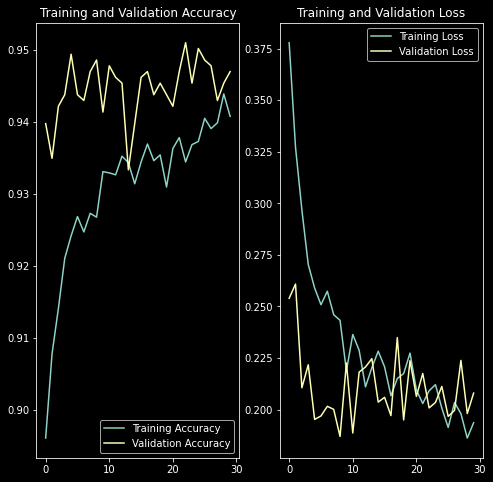

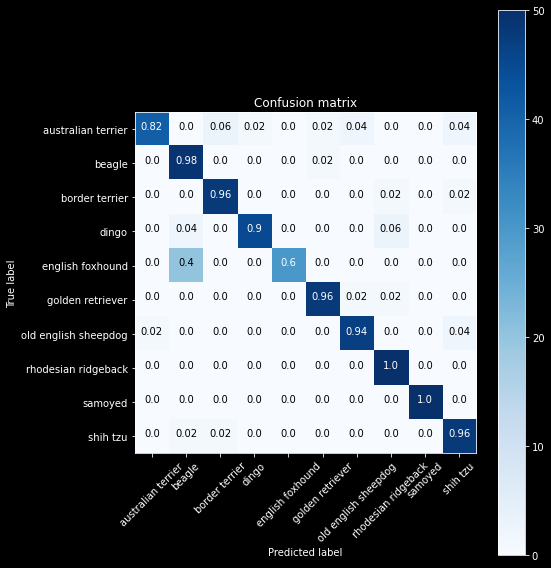

In [27]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    class_weight=class_weight
)
val_result = model.evaluate(val_data)
print(f"Final validation results: {dict(zip(model.metrics_names, val_result))}")
result = model.evaluate(test_data)
print(f"Final test results: {dict(zip(model.metrics_names, result))}")
plot_training(history)
# print(f"FLOPS: {get_flops(model)}")
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_data.classes, y_pred)
print(classification_report(test_data.classes, y_pred, target_names=test_data.class_indices.keys()))
plot_confusion_matrix(cm, test_data.class_indices.keys())

 note: step 2 crashed in notebook, moved to other laptop with 6GB graphics card

Step 2 - unfreeze res5c block and retrain final layers and added classifier

In [31]:
resnet.trainable = True

res5c = 0
trainable_layer_count = 0
for layer in resnet.layers:
    if layer.name[0:5] == "conv5":
        res5c = 1
    if not res5c:
        layer.trainable = False
    if layer.trainable:
        trainable_layer_count += 1
        print(layer.name)

print(f"{trainable_layer_count} trainable layers")
resnet.summary()

conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_conv
conv5_block1_2_bn
conv5_block1_2_relu
conv5_block1_0_conv
conv5_block1_3_conv
conv5_block1_0_bn
conv5_block1_3_bn
conv5_block1_add
conv5_block1_out
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_3_bn
conv5_block2_add
conv5_block2_out
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
32 trainable layers
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
_______________________________________________________________

In [32]:
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

gone from 527k trainable params to 15.5million

In [ ]:
# as per Chollet's advice, v small learning rate when fine-tuning
# https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
)

Epoch 1/100
351/351 [==============================] - 106s 289ms/step - loss: 0.1581 - accuracy: 0.9567 - val_loss: 0.3434 - val_accuracy: 0.9398

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_datagen.flow_from_directory(
    f"{data_fldr}/imagewoof-320/val",
    batch_size=32,
    target_size=(244, 244),
    shuffle=False,
    class_mode='categorical')

val_result = model.evaluate(val_data)
print(f"Final validation results: {dict(zip(model.metrics_names, val_result))}")
result = model.evaluate(test_data)
print(f"Final test results: {dict(zip(model.metrics_names, result))}")
plot_training(history)
# print(f"FLOPS: {get_flops(model)}")
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_data.classes, y_pred)
print(classification_report(test_data.classes, y_pred, target_names=test_data.class_indices.keys()))
plot_confusion_matrix(cm, test_data.class_indices.keys())

# save fine-tuned model trained on imbalanced dataset
model.save("../saved_models/initial_imbalanced.h5")

manually finding images "in the wild" (from Pinterest image sources)


In [ ]:
dog_img_urls = {
    "shih tzu": [
        "https://i.pinimg.com/474x/2c/63/70/2c63706dc8a38fac474b54fcf490e64a.jpg",
        "https://i.pinimg.com/474x/9c/5c/4c/9c5c4c97992c05622a9d373a9dd64981--shih-tzus-shih-tzu-puppy.jpg",
        "https://i.pinimg.com/474x/f0/2d/6b/f02d6bf6ae06c3de104c7f3e28f1d9ac.jpg",
        "https://i.pinimg.com/474x/20/ee/dc/20eedcb23f3a30adc78d0ccfb3ba2402--animal-pics-sweet.jpg",
        "https://i.pinimg.com/474x/de/4d/08/de4d08e8c8146a001265d2b34869be5a.jpg"
    ],
    "samoyed": [
        "https://i.pinimg.com/474x/92/71/03/927103cb769ffa4dc16c8a4c91d3c76e.jpg",
        "https://i.pinimg.com/474x/d0/64/f8/d064f8db12669c1c366563f9bbbb95d9.jpg",
        "https://i.pinimg.com/474x/5b/47/95/5b47957bc2d6dd3645e349d5a25ce135.jpg",
        "https://i.pinimg.com/474x/d2/35/3d/d2353d4d367202f8f33e896d430d0267.jpg",
        "https://i.pinimg.com/474x/1d/2f/fd/1d2ffd8f5131897b39cba1ddc541ff71.jpg",
    ],
    "rhodesian ridgeback": [
        "https://i.pinimg.com/474x/2c/36/cd/2c36cd56a8aa170ad52fc8f349cadc69.jpg",
        "https://i.pinimg.com/474x/cb/43/40/cb43402aad8a80a5631214e0dfa7273d.jpg",
        "https://i.pinimg.com/474x/7e/2e/5a/7e2e5a4eee78a8e1d740eaf3f45ef1e2.jpg",
        "https://i.pinimg.com/474x/8f/9f/b4/8f9fb4b7061d657c1b9c236c87482ada.jpg",
        "https://i.pinimg.com/474x/5d/cd/4c/5dcd4c108bffa5fcbed2527983a3a73a--rodesian-ridgeback-isa.jpg",
    ],
    "old english sheepdog": [
        "https://i.pinimg.com/474x/6a/5c/d6/6a5cd6ebbb939ff4e77a474f5080b047.jpg",
        "https://i.pinimg.com/474x/6d/cd/c1/6dcdc144bfa9e308635c8d3637a6d5ac.jpg",
        "https://i.pinimg.com/474x/cd/0d/06/cd0d068a27396f4a4d7a597531576dac.jpg",
        "https://i.pinimg.com/474x/66/4d/50/664d5015d83fbcc25b6b0b681e9bb34e.jpg",
        "https://i.pinimg.com/474x/52/be/0d/52be0d13a3a87281b2b971687ec273c3.jpg",
    ],
    "golden retriever": [
        "https://i.pinimg.com/474x/ba/63/75/ba63752f89f2707c76a96677c228754b.jpg",
        "https://i.pinimg.com/474x/3a/53/0f/3a530f1b2f22093b59012f7a47f6e6a4.jpg",
        "https://i.pinimg.com/474x/40/b6/c6/40b6c6fbe45d8284118a541c229e28df.jpg",
        "https://i.pinimg.com/474x/59/de/de/59dede67a5e089267b077e72be7b6903.jpg",
        "https://i.pinimg.com/474x/e5/3c/a0/e53ca0dc2ed6e29a8c66daa6213770a1.jpg",
    ],
    "english foxhound": [
        "https://i.pinimg.com/474x/91/16/8f/91168fa691c87f3ed7ccf18bc33e6c14.jpg",
        "https://i.pinimg.com/474x/12/6a/b5/126ab5b5a90f1608c29ac0f8d788a125.jpg",
        "https://i.pinimg.com/474x/5c/1e/79/5c1e79261214a3f9965e183f59d37e58.jpg",
        "https://i.pinimg.com/474x/ff/01/61/ff0161ab7a4638338416d8ff424bb2e3.jpg",
        "https://i.pinimg.com/474x/8d/02/35/8d02351a3db0920907c4ed1d583f151c.jpg",
    ],
    "dingo": [
        "https://i.pinimg.com/474x/21/33/42/21334265e2135acf693c18a82dbe67f5.jpg",
        "https://i.pinimg.com/474x/e4/b9/8b/e4b98b262685e47cce3d429990a909a3.jpg",
        "https://i.pinimg.com/474x/e9/3d/e2/e93de29f36037732c3fbfedbbef4ee18.jpg",
        "https://i.pinimg.com/474x/47/74/d1/4774d126ca26eea15342698cb82c50a7.jpg",
        "https://i.pinimg.com/474x/dd/dc/04/dddc04b8888adc55a9e5f78bdde50952--australian-animals-wild-dogs.jpg",
    ],
    "border terrier": [
        "https://i.pinimg.com/474x/46/51/9b/46519b9ac283dca49b2c3cd7bacb0409.jpg",
        "https://i.pinimg.com/474x/2b/3e/06/2b3e06094e0e2bbbca46d82fb87ffc29.jpg",
        "https://i.pinimg.com/474x/ba/35/95/ba3595447afeb3c53e6cc824903b4ae0.jpg",
        "https://i.pinimg.com/474x/8e/a8/9a/8ea89ab59164e3f2beea88028942cedf.jpg",
        "https://i.pinimg.com/474x/47/89/38/478938357602dd81dc8fd8d85a8a0d5e.jpg",
    ],
    "beagle": [
        "https://i.pinimg.com/474x/a7/52/5e/a7525e7370d4401a1862b48b044d0047.jpg",
        "https://i.pinimg.com/474x/0e/23/8c/0e238cad026054885fa0f9a3d67920be.jpg",
        "https://i.pinimg.com/474x/29/c8/b2/29c8b25370ebb078c6badd41612957b0.jpg",
        "https://i.pinimg.com/474x/2b/fc/ef/2bfcefb172f6a0d32a5aa93ae9922518.jpg",
        "https://i.pinimg.com/474x/53/be/97/53be97011b5247dfd8f0bfd239fd55bf.jpg",
    ],
    "australian terrier": [
        "https://i.pinimg.com/474x/f6/8d/e7/f68de7acecd75e5a20dd0fc810c9c458.jpg",
        "https://i.pinimg.com/474x/c5/5c/3f/c55c3f025e5266ef543b378ea4e0791e.jpg",
        "https://i.pinimg.com/474x/94/87/ea/9487ea41f05fc155f7c5c22529d45c10.jpg",
        "https://i.pinimg.com/474x/10/70/22/10702208b21795153d4f8c7cedf6c9fd.jpg",
        "https://i.pinimg.com/474x/b4/f7/85/b4f785bfe18fe182c6ebfc7040d3d614--silky-terrier-terrier-mix.jpg",
    ],
}

In [2]:
import utils
utils.convert_pb_to_h5("initial_imbalanced", f"{utils.project_fldr}/transfer_learning_2/saved_models")

In [1]:
import tensorflow as tf
def load_pb(pb_model):
    with tf.compat.v1.gfile.GFile(pb_model, "rb") as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')
        return graph

def estimate_flops(pb_model):
    graph = load_pb(pb_model)
    with graph.as_default():
        # placeholder input would result in incomplete shape. So replace it with constant during model frozen.
        flops = tf.compat.v1.profiler.profile(graph, options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation())
        print('Model {} needs {} FLOPS after freezing'.format(pb_model, flops.total_float_ops))

model = "../saved_models/initial_imbalanced/saved_model.pb"
estimate_flops(model)

DecodeError: Error parsing message

In [ ]:
# adapted from Paul Whelan's course notes
def smoothing(data, f=0.8):
    smoothed = []
    for d in data:
        smoothed_point = (smoothed[-1] * f + d * (1 - f)) if smoothed else d
        smoothed.append(smoothed_point)
    return smoothed